# **Credit Card Fraud Detection with Decision Trees and SVM**

I will consolidate your machine learning (ML) modeling skills by using two popular classification models to identify fraudulent credit card transactions. These models are: Decision Tree and Support Vector Machine. I will use a real dataset of credit card transactions to train each of these models.I will then use the trained model to assess if a credit card transaction is fraudulent or not.


#### Objectives
* Perform basic data preprocessing in Python
* Model a classification task using the Scikit-Learn Python APIs
* Train Suppport Vector Machine and Decision Tree models using Scikit-Learn
* Run inference and assess the quality of the trained models

In [ ]:
pip install pandas numpy scikit-learn matplotlib

In [5]:
# Import the libraries we need to use
from __future__ import print_function
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize, StandardScaler
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
from sklearn.svm import LinearSVC
import requests

import warnings
warnings.filterwarnings('ignore')

In [8]:
# download the dataset
url= "https://creditcard.csv"

# read the input data
raw_data=pd.read_csv(url)
raw_data.head(10)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
5,2.0,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,-0.568671,...,-0.208254,-0.559825,-0.026398,-0.371427,-0.232794,0.105915,0.253844,0.081080,3.67,0
6,4.0,1.229658,0.141004,0.045371,1.202613,0.191881,0.272708,-0.005159,0.081213,0.464960,...,-0.167716,-0.270710,-0.154104,-0.780055,0.750137,-0.257237,0.034507,0.005168,4.99,0
7,7.0,-0.644269,1.417964,1.074380,-0.492199,0.948934,0.428118,1.120631,-3.807864,0.615375,...,1.943465,-1.015455,0.057504,-0.649709,-0.415267,-0.051634,-1.206921,-1.085339,40.80,0
8,7.0,-0.894286,0.286157,-0.113192,-0.271526,2.669599,3.721818,0.370145,0.851084,-0.392048,...,-0.073425,-0.268092,-0.204233,1.011592,0.373205,-0.384157,0.011747,0.142404,93.20,0
9,9.0,-0.338262,1.119593,1.044367,-0.222187,0.499361,-0.246761,0.651583,0.069539,-0.736727,...,-0.246914,-0.633753,-0.120794,-0.385050,-0.069733,0.094199,0.246219,0.083076,3.68,0


<div id="dataset_analysis">
    <h2>Dataset Analysis</h2>
</div>
 
Each row in the dataset represents a credit card transaction. Each row has 31 variables. One variable (the last variable in the table above) is called Class and represents the target variable. Our objective will be to train a model that uses the other variables to predict the value of the Class variable. Let's first retrieve basic statistics about the target variable.

Note: For confidentiality reasons, the original names of most features are anonymized V1, V2 .. V28. The values of these features are the result of a PCA transformation and are numerical. The feature 'Class' is the target variable and it takes two values: 1 in case of fraud and 0 otherwise.

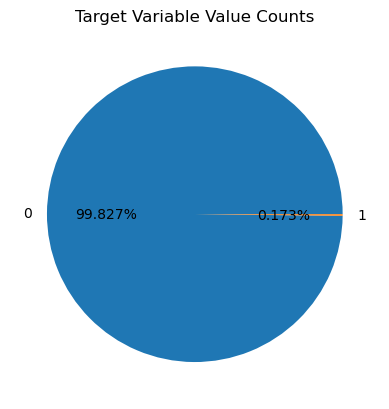

In [9]:
# get the set of distinct classes
labels = raw_data.Class.unique()

# get the count of each class
sizes = raw_data.Class.value_counts().values

# plot the class value counts
fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.3f%%')
ax.set_title('Target Variable Value Counts')
plt.show()

As shown above, the Class variable has two values: 0 (the credit card transaction is legitimate) and 1 (the credit card transaction is fraudulent). Thus, We need to model a binary classification problem. Moreover, the dataset is highly unbalanced, the target variable classes are not represented equally. This case requires special attention when training or when evaluating the quality of a model. One way of handing this case at train time is to bias the model to pay more attention to the samples in the minority class. The models under the current study will be configured to take into account the class weights of the samples at train/fit time.


<Axes: >

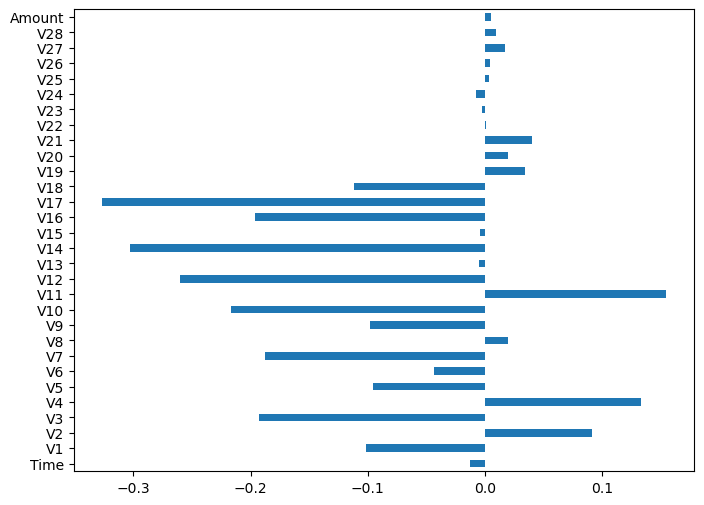

In [18]:
correlation_values = raw_data.corr()['Class'].drop('Class')
correlation_values.plot(kind='barh', figsize=(8, 6))

This clearly shows that some features affect the output Class more than the others. For efficient modeling, we may use only the most correlated features.

<div id="dataset_preprocessing">
    <h2>Dataset Preprocessing</h2>
</div>


We will now prepare the data for training. We will apply standard scaling to the input features and normalize them using $L_1$ norm for the training models to converge quickly. As seen in the data snapshot, there is a parameter called `Time` which we will not be considering for modeling. Hence, features 2 to 30 will be used as input features and feature 31, i.e. Class will be used as the target variable.

In [19]:
# standardize features by removing the mean and scaling to unit variance
raw_data.iloc[:, 1:30] = StandardScaler().fit_transform(raw_data.iloc[:, 1:30])
data_matrix = raw_data.values

# X: feature matrix (for this analysis, we exclude the Time variable from the dataset)
X = data_matrix[:, 1:30]

# y: labels vector
y = data_matrix[:, 30]

# data normalization
X = normalize(X, norm="l1")

<div id="dataset_split">
    <h2>Dataset Train/Test Split</h2>
</div>

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

<div id="dt_sklearn">
    <h2>Build a Decision Tree Classifier model with Scikit-Learn</h2>
</div>

Compute the sample weights to be used as input to the train routine so that it takes into account the class imbalance present in this dataset.

In [21]:
w_train = compute_sample_weight('balanced', y_train)

Using these sample weights, we may train the Decision Tree classifier. We also make note of the time it takes for training this model to compare it against SVM, later.

In [22]:
# for reproducible output across multiple function calls, set random_state to a given integer value
dt = DecisionTreeClassifier(max_depth=4, random_state=35)

dt.fit(X_train, y_train, sample_weight=w_train)

DecisionTreeClassifier(max_depth=4, random_state=35)

<div id="svm_sklearn">
    <h2>Build a Support Vector Machine model with Scikit-Learn</h2>
</div>

Unlike Decision Trees, we do not need to initiate a separate sample_weight for SVMs. We can simply pass a parameter in the scikit-learn function.

In [23]:
# for reproducible output across multiple function calls, set random_state to a given integer value
svm = LinearSVC(class_weight='balanced', random_state=31, loss="hinge", fit_intercept=False)

svm.fit(X_train, y_train)

LinearSVC(class_weight='balanced', fit_intercept=False, loss='hinge',
          random_state=31)

<div id="dt_sklearn_snapml">
    <h2>Evaluate the Decision Tree Classifier Models</h2>
</div>

In [25]:
y_pred_dt = dt.predict_proba(X_test)[:,1]  #Compute the probabilities of the test samples belonging to the class of fraudulent transactions.

Using these probabilities, we can evaluate the Area Under the Receiver Operating Characteristic Curve (ROC-AUC) score as a metric of model performance. 
The AUC-ROC score evaluates your model's ability to distinguish positive and negative classes considering all possible probability thresholds. The higher its value, the better the model is considered for separating the two classes of values.

In [26]:
roc_auc_dt = roc_auc_score(y_test, y_pred_dt)
print('Decision Tree ROC-AUC score : {0:.3f}'.format(roc_auc_dt))

Decision Tree ROC-AUC score : 0.939


<div id="svm_sklearn_snap">
    <h2>Evaluate the Support Vector Machine Models</h2>
</div>

In [27]:
y_pred_svm = svm.decision_function(X_test)

In [28]:
roc_auc_svm = roc_auc_score(y_test, y_pred_svm)
print("SVM ROC-AUC score: {0:.3f}".format(roc_auc_svm))

SVM ROC-AUC score: 0.986
